## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [37]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def descale(X, X_old):
    return (X_old.max(axis=0) - X_old.min(axis=0)) * X + X_old.min(axis=0)

In [38]:
x = np.arange(100, dtype=float)
xnew = scale(x)
print(x)
print(descale(x, scale(x)))
# assert np.array_equal(x, descale(x, scale(x)))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [39]:
# Load the data
df = pd.read_pickle('./data/transfer-functions.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-28.17844516431674, -29.995330137199815, -26...."
1,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.519000119295377, -20.82520269965962, -23...."
2,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.78282633317538, -23.116844835167647, -23...."
3,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-19.483532441089714, -25.181283644031062, -34..."
4,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-24.21908363783242, -27.164085696072963, -24...."


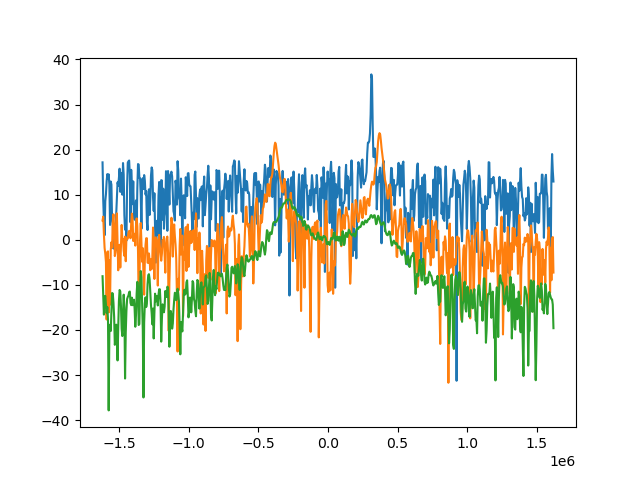

In [40]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [41]:
# Extract the target variables
param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x
df.drop(columns='x', inplace=True)

In [42]:
# target is the target vector
target = np.array((param_a, param_b)).T
scaled_target = scale(target)
# target = torch.tensor(target, dtype=torch.float32)
print(target[5:15])
# scaler_target = preprocessing.MinMaxScaler()
scaled_target = torch.tensor(scaled_target, dtype=torch.float32)
print(scaled_target[5:15])

[[-2.00000000e+01  1.00000000e-04]
 [-2.00000000e+01  1.00000000e-04]
 [-2.00000000e+01  1.00000000e-04]
 [-2.00000000e+01  1.00000000e-04]
 [-2.00000000e+01  1.00000000e-04]
 [-2.00000000e+01  6.21052632e-04]
 [-2.00000000e+01  6.21052632e-04]
 [-2.00000000e+01  6.21052632e-04]
 [-2.00000000e+01  6.21052632e-04]
 [-2.00000000e+01  6.21052632e-04]]
tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0526],
        [0.0000, 0.0526],
        [0.0000, 0.0526],
        [0.0000, 0.0526],
        [0.0000, 0.0526]])


In [43]:
# Only the input points have been left
df.head()

,y
0,"[-28.17844516431674, -29.995330137199815, -26...."
1,"[-21.519000119295377, -20.82520269965962, -23...."
2,"[-22.78282633317538, -23.116844835167647, -23...."
3,"[-19.483532441089714, -25.181283644031062, -34..."
4,"[-24.21908363783242, -27.164085696072963, -24...."


In [44]:
values = np.zeros((len(df), len(df.iloc[0,0])), dtype=float)
# print(values.shape)
for index, row in df.iterrows():
    values[index, :] = row.values[0]
print(values.shape)
print(type(values))

(8200, 662)
<class 'numpy.ndarray'>


In [45]:
# Convert data to torch tensor
# scaler_data = preprocessing.MinMaxScaler()
scaled_values = scale(values)
data = torch.tensor(scaled_values, dtype=torch.float32)
print(data)

tensor([[0.2562, 0.3226, 0.3338,  ..., 0.3968, 0.3766, 0.4237],
        [0.3332, 0.4195, 0.3707,  ..., 0.3503, 0.3847, 0.3687],
        [0.3186, 0.3953, 0.3623,  ..., 0.4225, 0.4457, 0.4358],
        ...,
        [0.4872, 0.6092, 0.5983,  ..., 0.6054, 0.6212, 0.5373],
        [0.5119, 0.6076, 0.6109,  ..., 0.5045, 0.5319, 0.5286],
        [0.4926, 0.5934, 0.5760,  ..., 0.4587, 0.5133, 0.5598]])


In [46]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, scaled_target, test_size=0.2, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([6560, 662])
torch.Size([1640, 662])
torch.Size([6560, 2])
torch.Size([1640, 2])


In [47]:
# Define the network architecture

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 64
        kernel_size = 5
        stride = 1
        padding = 0
        # n_pool_out = (n_inputs + 2 * padding - kernel_size)//stride +1
        n_pool_out = n_inputs


        # normalize input, it can help with training
        # self.norm = nn.BatchNorm1d(n_inputs)

        # First apply an avgpooling layer to smoothen the curve
        # self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        # linear layer (n_pool_out -> hidden_1)

        self.fc1 = nn.Linear(n_pool_out, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> n_outputs)
        self.fc3 = nn.Linear(hidden_2, n_outputs)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        # x = x.view(-1, 28 * 28)
        # x = self.pool1(x)
        # add hidden layer, with relu activation function

        # x = self.norm(x)

        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


    def get_accuracy(self, pred_arr, original_arr, pct=0.1):
        n_correct = torch.sum((torch.abs(pred_arr-original_arr) < torch.abs(pct * original_arr)))
        acc = (n_correct.item() * 100.0 / len(original_arr))
        return acc


    def save(self, name='model.pt'):
        torch.save(self.state_dict(), name)


    def train_net(self, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=100):
        l_train_loss=[]
        l_train_accuracy=[]
        l_test_loss=[]
        l_test_accuracy=[]
        min_test_loss = np.Inf
        for epoch in range(num_epochs):
            # put the model in training mode
            self.train()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output_train = model(X_train)

            # l_train_accuracy.append(self.get_accuracy(output_train, y_train))

            #calculate the loss
            train_loss = criterion(output_train, y_train)
            l_train_loss.append(train_loss.item())

            #backward pass: compute gradient of the loss with respect to model parameters
            train_loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            with torch.no_grad():
                output_test = model(X_test)
                test_loss = criterion(output_test, y_test)
                l_test_loss.append(test_loss.item())
                # l_test_accuracy.append(self.get_accuracy(output_test, y_test))

            if l_test_loss[-1] < min_test_loss:
                print(f"Epoch {epoch+1}/{num_epochs}: Test loss decreased ({min_test_loss:.6f} --> {l_test_loss[-1]:.6f}), saving model.")
                self.save('model.pt')
                min_test_loss = l_test_loss[-1]

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {l_train_loss[-1]:.4f}, Test Loss: {l_test_loss[-1]:.2f}")

        return l_train_loss, l_train_accuracy, l_test_loss, l_test_accuracy


In [48]:
# Initialize model, loss function and optimizer

n_inputs = data.shape[1]
n_outputs = scaled_target.shape[1]
model = Net(n_inputs, n_outputs)
print(model)

# specify loss function (regression)
criterion = nn.MSELoss(); criterion_name = 'MSE'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=662, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [54]:
# train the network
train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(optimizer, criterion, X_train, y_train, X_test, y_test, 500)

Epoch 1/500: Test loss decreased (inf --> 0.043538), saving model.
Epoch 3/500: Test loss decreased (0.043538 --> 0.042979), saving model.
Epoch 5/500: Test loss decreased (0.042979 --> 0.042630), saving model.
Epoch 5/500, Train Loss: 0.0434, Test Loss: 0.04
Epoch 10/500: Test loss decreased (0.042630 --> 0.042242), saving model.
Epoch 10/500, Train Loss: 0.0426, Test Loss: 0.04
Epoch 14/500: Test loss decreased (0.042242 --> 0.042226), saving model.
Epoch 15/500, Train Loss: 0.0417, Test Loss: 0.04
Epoch 20/500, Train Loss: 0.0442, Test Loss: 0.05
Epoch 24/500: Test loss decreased (0.042226 --> 0.041926), saving model.
Epoch 25/500, Train Loss: 0.0436, Test Loss: 0.04
Epoch 30/500, Train Loss: 0.0429, Test Loss: 0.04
Epoch 35/500, Train Loss: 0.0443, Test Loss: 0.05
Epoch 40/500, Train Loss: 0.0429, Test Loss: 0.04
Epoch 45/500, Train Loss: 0.0422, Test Loss: 0.05
Epoch 47/500: Test loss decreased (0.041926 --> 0.041632), saving model.
Epoch 48/500: Test loss decreased (0.041632 --> 

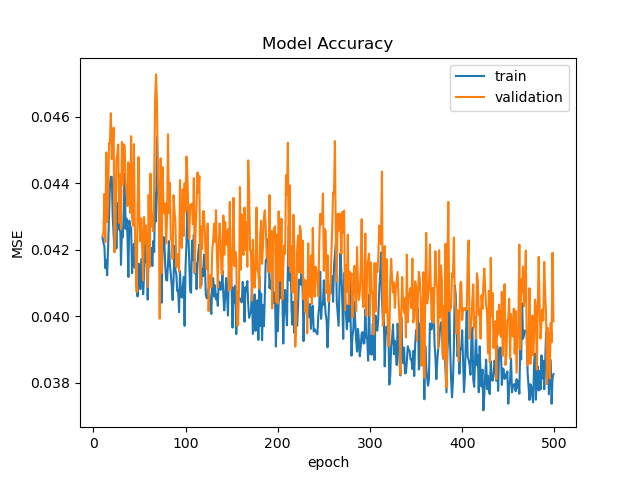

In [55]:
# plot train and validation loss
%matplotlib widget

def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel(criterion_name)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

plot_loss(train_loss, test_loss, epoch=(10,-1))

In [51]:
# load model with highest accuracy
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [58]:
# make predictions
model.eval()
random_idx = np.random.choice(np.arange(len(X_test)), size=3, replace=False)
X_validate = X_test[random_idx]
y_validate = y_test[random_idx]
with torch.no_grad():
    yhat = model(X_validate)
print('Original: ', y_validate)
print('Predicted:', yhat)

Original:  tensor([[0.1000, 0.4211],
        [0.9250, 0.7895],
        [0.7750, 0.3684]])
Predicted: tensor([[0.4925, 0.5492],
        [0.7823, 0.6250],
        [0.5517, 0.3005]])


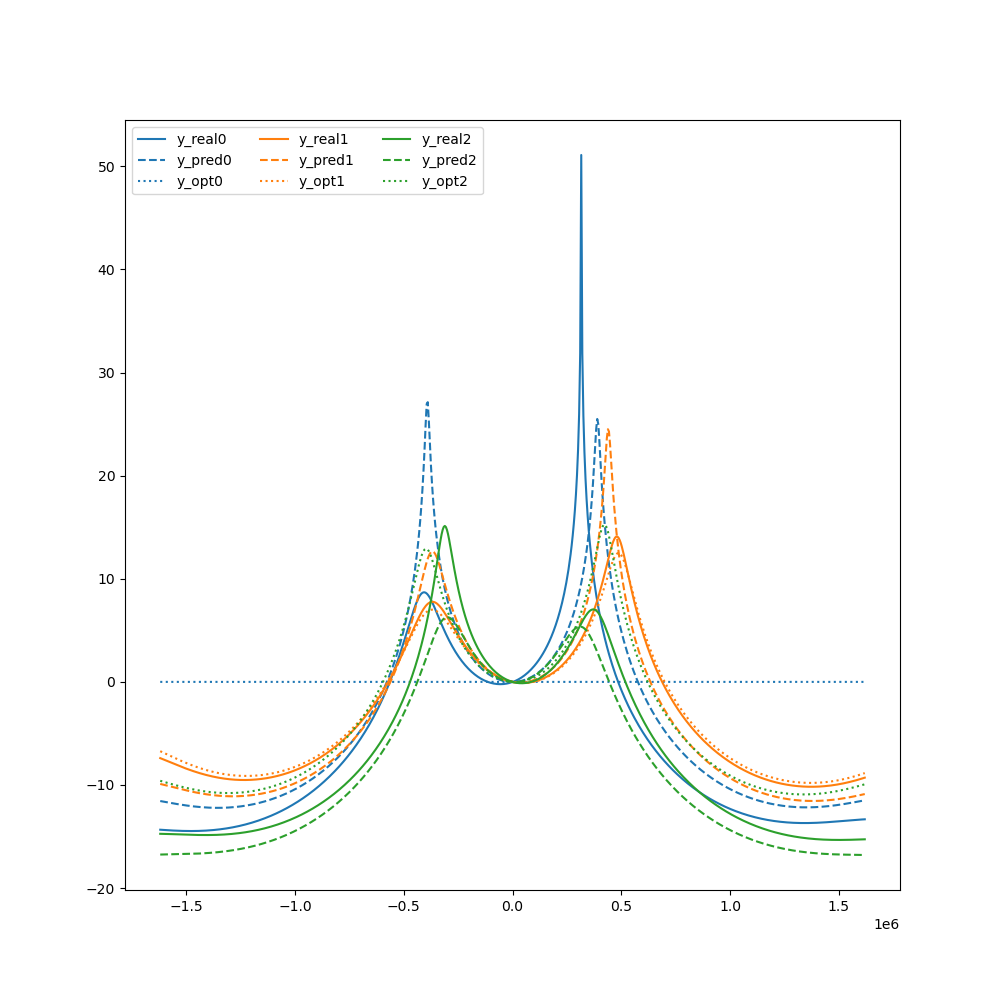

In [59]:
# plot the validation curves
%matplotlib widget
from scipy.optimize import curve_fit
plt.figure(figsize=(10, 10))
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
x = gen_tf.frequency
y_validate = descale(y_validate.numpy(), target)
yhat = descale(yhat.numpy(), target)
X_validate = descale(X_validate.numpy(), values)
for idx in range(len(y_validate)):
    y_real = gen_tf(x, *(y_validate[idx]))
    y_pred = gen_tf(x, *(yhat[idx]))
    try:
        popt, pcov  = curve_fit(gen_tf, x, X_validate[idx])
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue
    p = plt.plot(x, y_real, label=f'y_real{idx}', ls='-')
    plt.plot(x, y_pred, label=f'y_pred{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, gen_tf(x, *popt), label=f'y_opt{idx}', ls=':', color=p[0].get_color())
plt.legend(ncol=3)
plt.show()

In [ ]:
# evaluate our model
def evaluate_model(X, y):
    results = list()
    n_inputs = X.shape[1]
    n_outputs = y.shape[1]
        # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = tf.gather(X, train_ix), tf.gather(X, test_ix)
        y_train, y_test = tf.gather(y, train_ix), tf.gather(y, test_ix)

        # X_train, X_test = tf_data[train_ix], tf_data[test_ix]
        # y_train, y_test = tf_target[train_ix], tf_target[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    print('MAE: %3f (%.3f)' % (np.mean(results), np.std(results)))
    return results